In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set_theme(style="white")

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.cluster import KMeans, SpectralClustering

from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist
from scipy import stats

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm
import src.plotting as plotting


from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings'

#the directory has other csvs and i only want today's
#file = [file for file in os.listdir(embedding_dir) if file.startswith("022822")] 
file = '022822_postpartum_moms_20part_emb_ami.csv'

#create a dictionary where each item is the pd df of the embeddings extracted from that model
#all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}
emb = ee.load_embs(os.path.join(embedding_dir,file))

#choose 'emb_ami' as the embedding model to use because it seemed to result in best preserved high-dimension structure when dimension reduced
#emb = all_embs[emb_models[0]]
emb_down = ee.resample_data(emb,1)

#average emebdding for each participant
emb_a = ee.embedding_averager(emb_down)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
plist = emb_down.part_id.unique().astype('int32') 

#loo is leave one out. Creates a dictionary of the downsampled embeddings with the format: {participant_removed:embeddings} for each participant
loo = {'rm' + str(p):
       emb_down[emb_down.part_id!=plist[idx]].reset_index(drop=True) 
       for idx,p in enumerate(plist)
      }
plist

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20], dtype=int32)

In [5]:
# Reduces dimensions of every set of leave-one-out
#Creates a dictionary: {participant_removed::two-dimension embeddings} for each participant with either tnse or umap

loo_tsne = {rm:dr.run_tsne(ed, perplexity=80, init='pca', learning_rate=emb_down.shape[0]//12) for rm, ed in loo.items()}            

In [6]:
loo_umap = {rm:dr.run_umap(ed) for rm, ed in loo.items()}

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
#Calculates hausdorf distances between each participants point-cloud after dim reduc
#Creates a dictionary: {participant_removed:hausdorf distance} for each participant
#with hausdorff distances between each participant's two-dimension point-cloud, on either the tsne or umap

loo_haus_tsne = {rm:dm.hausdorff_distances(e2d) for rm, e2d in loo_tsne.items()}
loo_haus_umap = {rm:dm.hausdorff_distances(e2d) for rm, e2d in loo_umap.items()}

Processing row 18, col 18


In [8]:
#flatten the hausdorf distances for plotting and only get column 2 which has the distances (0 and 1 have the pairs of participants)
loo_haus_tsne_flat = {rm:
                      haus.stack().reset_index().iloc[:,2] 
                      for rm,haus in loo_haus_tsne.items()
                     }

loo_haus_tsne_flat = {rm:haus[haus>0] for rm,haus in loo_haus_tsne_flat.items()}

In [14]:
metrics = {rm:dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        subsetsize=X.shape[0]
)
 for ([rm,X],Z) in zip(loo.items(), loo_tsne.values())
}

#metrics = {rm:dm.embedding_quality(
#        emb_down.drop(columns='part_id').to_numpy(), 
#        Z.drop(columns='part_id').to_numpy(), 
#        emb_down.part_id.to_numpy(),
#        subsetsize=1000
#)
# for rm,Z in loo_tsne.items()
#}


metrics = pd.DataFrame(metrics.values(), columns=['micro', 'meso', 'macro'], index = metrics.keys())
metrics.mean(axis=0)


micro    0.271056
meso     0.806053
macro    0.593348
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

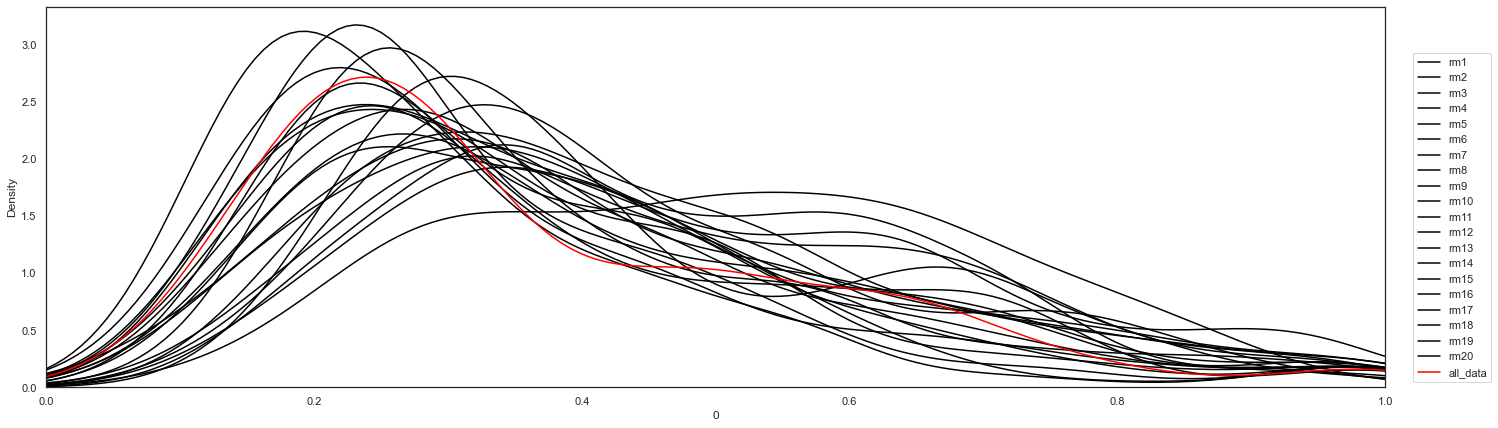

In [44]:
#plots distribution all hausdorff distances. Technically a histogram with easily viewing
fig, ax = plt.subplots(figsize=(24,7))#ncols=3
bins=100

d_plot = [sns.distplot(dist,hist=False, norm_hist=True,label=rm,color='black') for rm,dist in loo_haus_tsne_flat.items()]
a_plot = sns.distplot(haus_tsne_flat,hist=False, norm_hist=True,label='all_data',color='red')
ax.legend(loc="lower center",bbox_to_anchor=(1.05, 0), ncol=1)
plt.xlim(0,1)
plt.show

In [40]:
#Using tsne with perplexity=30 (default) since N/100<30, and learning rate of n/12. Random seed is 42 so the result is the same each time
emb_tsne = dr.run_tsne(emb_down, perplexity=80, init='pca', learning_rate=emb_down.shape[0]//12)
haus_tsne = dm.hausdorff_distances(emb_tsne)

Processing row 19, col 19


In [33]:
haus_tsne_flat = haus_tsne.stack().reset_index().iloc[:,2]  

haus_tsne_flat = haus_tsne_flat[haus_tsne_flat>0]
haus_tsne_flat

1      0.201617
2      0.159276
3      0.213192
4      0.212280
5      0.275035
         ...   
394    0.387642
395    0.374027
396    0.191426
397    0.740169
398    0.231070
Name: 0, Length: 380, dtype: float64

In [37]:
#ttest = dm.loo_t_test(loo_haus_tsne_flat,equal_var=False)
ttest = [stats.ttest_ind(rm,haus_tsne_flat,equal_var=False) for rm in loo_haus_tsne_flat.values()]
a = pd.DataFrame(ttest)
np.sum(a.pvalue<0.05)

13

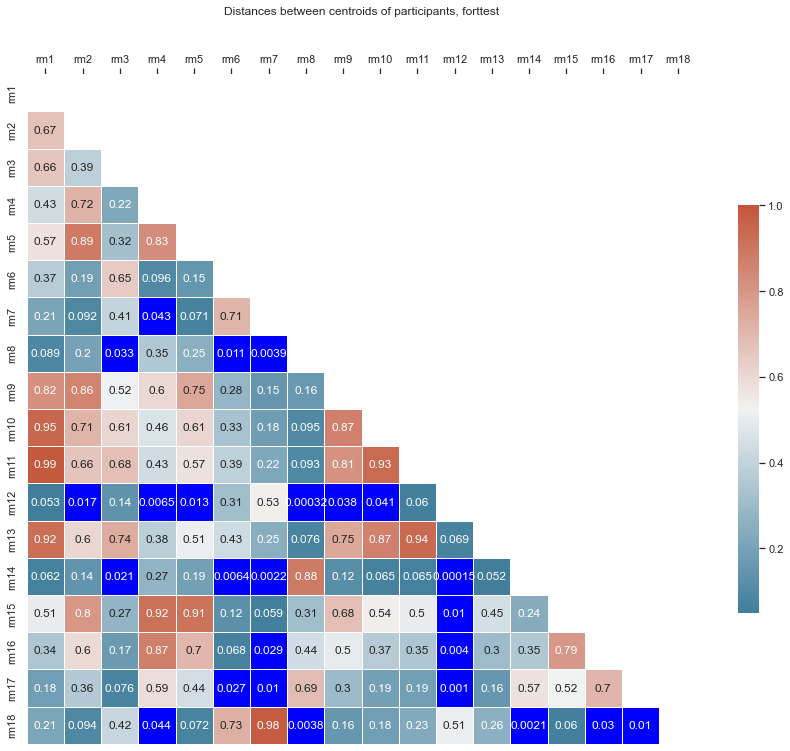

In [52]:
plotting.plot_norm_heatmap(ttest,'ttest')

In [74]:
temp = pd.DataFrame(np.triu(ttest, k=1).flatten())
temp = temp[temp>0].dropna()
temp.ge(0.05).mean().mul(100)


0    83.660131
dtype: float64

In [ ]:
reset_index